In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import warnings
from sklearn.cluster import DBSCAN


custom_palette = sns.color_palette('Set1')
plt.rcParams.update({'figure.figsize' : (12,6), 'axes.grid' : True})

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)
warnings.filterwarnings("ignore")

In [2]:
train = pd.read_csv('OG_DATA/train.csv')
test = pd.read_csv('OG_DATA/sample_submission.csv')
med = pd.read_csv('OG_DATA/med.csv')

db = train.copy()
iqr = train.copy()

train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40152 entries, 0 to 40151
Data columns (total 2 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Tarih                   40152 non-null  object 
 1   Dağıtılan Enerji (MWh)  40152 non-null  float64
dtypes: float64(1), object(1)
memory usage: 627.5+ KB


In [3]:
train.rename(columns={'Tarih' : 'date', 'Dağıtılan Enerji (MWh)' : 'target'},inplace=True)
train.date = pd.to_datetime(train.date)
train.date.nunique()

40152

In [4]:
train.isna().sum()

date      0
target    0
dtype: int64

In [5]:
train.describe().T

,count,mean,std,min,25%,50%,75%,max
target,40152.0,1836.805287,426.066085,870.18328,1499.165048,1813.409221,2129.407998,3633.105297


__Extracting calendar features__

In [6]:
def date_extractor(df):
    
    df['year'] = df.date.dt.year
    df['month'] = df.date.dt.month
    df['day_ofweek'] = df['date'].dt.dayofweek
    df['is_weekend'] = df.day_ofweek.apply(lambda x: 1 if x >= 5 else 0)
    df['day'] = df['date'].dt.day
    df['day_ofyear'] = df['date'].dt.dayofyear
    df['hour'] = df.date.dt.hour
    df['weekofyear'] = df['date'].dt.weekofyear
    df['quarter'] = df['date'].dt.quarter
    df['is_leap'] = df['date'].dt.is_leap_year.replace({False : 0, True : 1})
    
date_extractor(train)


season_map = {12: 'winter', 1: 'winter', 2: 'winter',
              3: 'spring', 4: 'spring', 5: 'spring',
              6: 'summer', 7: 'summer', 8: 'summer',
              9: 'fall', 10: 'fall', 11: 'fall'}

train['season'] = train.month.map(season_map)

train.set_index('date',inplace=True)

train['is_med'] = 0
train['is_med'].loc[med.Tarih.values] = 1

train

,target,year,month,day_ofweek,is_weekend,day,day_ofyear,hour,weekofyear,quarter,is_leap,season,is_med
date,,,,,,,,,,,,,
2018-01-01 00:00:00,1593.944216,2018,1,0,0,1,1,0,1,1,0,winter,0
2018-01-01 01:00:00,1513.933887,2018,1,0,0,1,1,1,1,1,0,winter,0
2018-01-01 02:00:00,1402.612637,2018,1,0,0,1,1,2,1,1,0,winter,0
2018-01-01 03:00:00,1278.527266,2018,1,0,0,1,1,3,1,1,0,winter,0
2018-01-01 04:00:00,1220.697701,2018,1,0,0,1,1,4,1,1,0,winter,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-07-31 19:00:00,2492.489498,2022,7,6,1,31,212,19,30,3,0,summer,0
2022-07-31 20:00:00,2479.958245,2022,7,6,1,31,212,20,30,3,0,summer,0
2022-07-31 21:00:00,2485.016884,2022,7,6,1,31,212,21,30,3,0,summer,0


***
## Testing and Decomposing

In [7]:
from statsmodels.tsa.seasonal import seasonal_decompose

from statsmodels.tsa.stattools import kpss

def kpss_test(df):
    kpss_res = kpss(df.target,'ct')

    if kpss_res[1] <= 0.05:
        print('Serie is non-stationary')
    else: 
        print('Serie is stationary')
        
kpss_test(train)

Serie is non-stationary


C:\Users\so24d\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\stattools.py:2018: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warnings.warn(


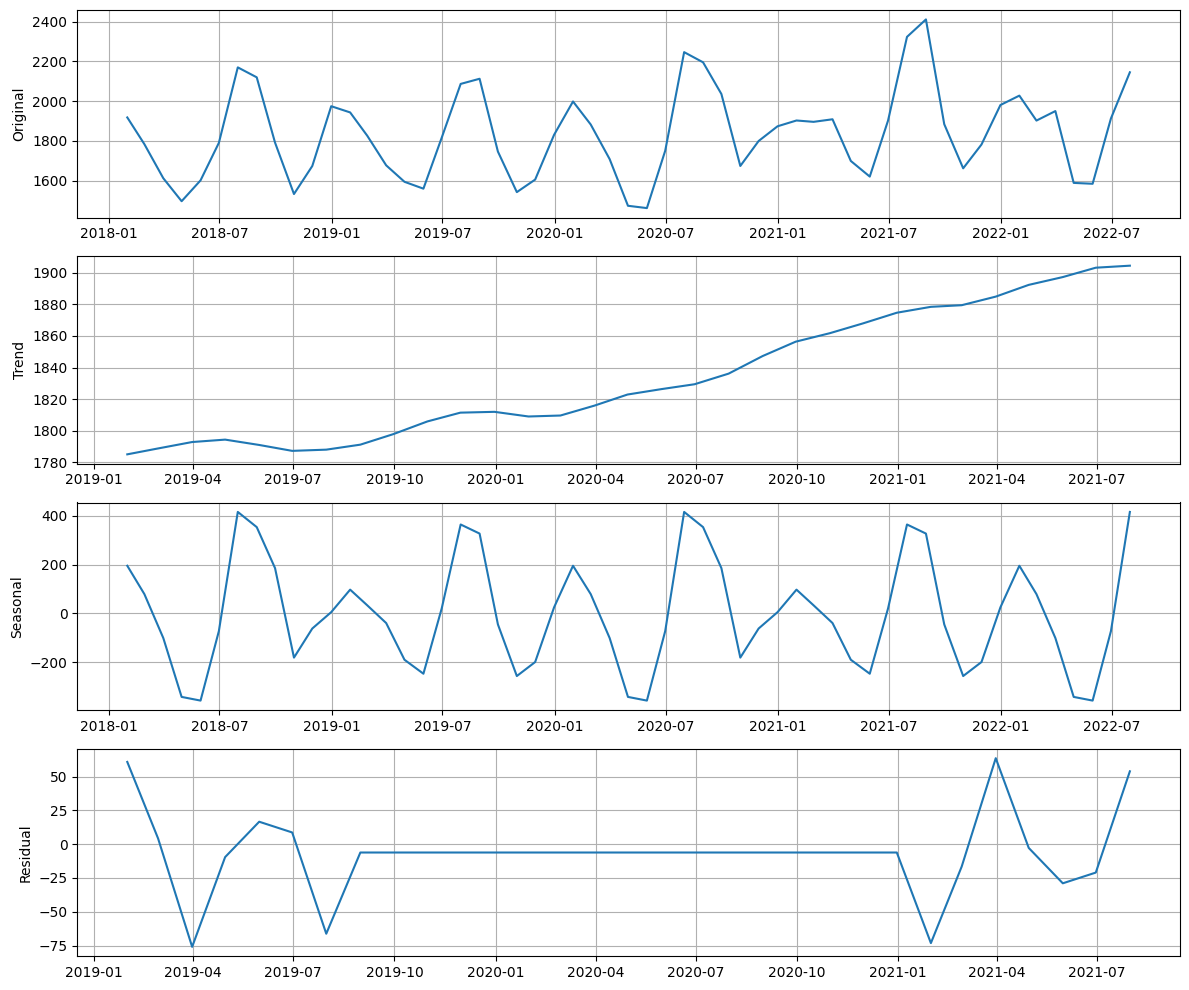

In [8]:
res = seasonal_decompose(train.target.resample('M').mean(), model='additive', period=24)

fig, ax = plt.subplots(4, 1, figsize=(12, 10))
ax[0].plot(train.target.resample('M').mean())
ax[0].set_ylabel('Original')
ax[1].plot(res.trend)
ax[1].set_ylabel('Trend')
ax[2].plot(res.seasonal)
ax[2].set_ylabel('Seasonal')
ax[3].plot(res.resid)
ax[3].set_ylabel('Residual')

plt.tight_layout()
plt.show()

__ACF - PACF Plots__

__Lagging a few hours and 24-48 hours seems highly correlated__

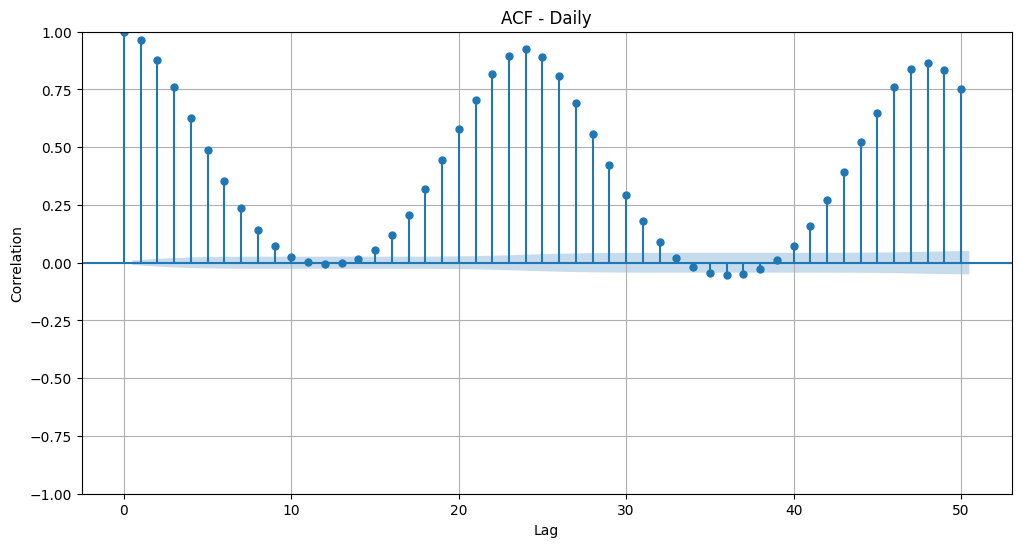

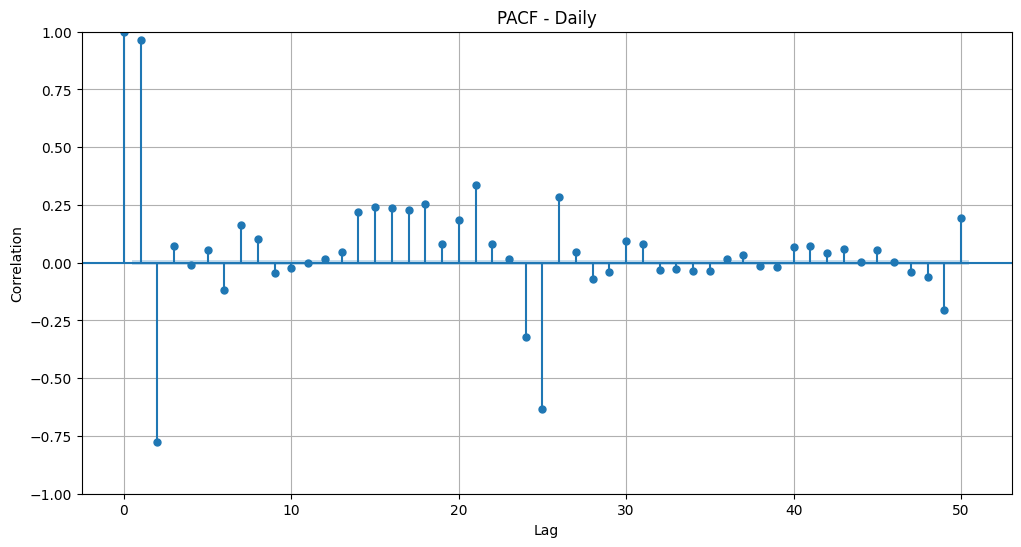

In [9]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

fig, ax = plt.subplots(figsize=(12, 6))
plot_acf(train.target, lags=50, ax=ax, alpha=0.05, use_vlines=True)
plt.title('ACF - Daily')
plt.xlabel('Lag')
plt.ylabel('Correlation')
plt.show()

fig, ax = plt.subplots(figsize=(12, 6))
plot_pacf(train.target, lags=50, ax=ax, alpha=0.05, use_vlines=True)
plt.title('PACF - Daily')
plt.xlabel('Lag')
plt.ylabel('Correlation')
plt.show()

__Lagging a few weeks are correlated, additionally we can say there is correlation at 12-14 weeks__

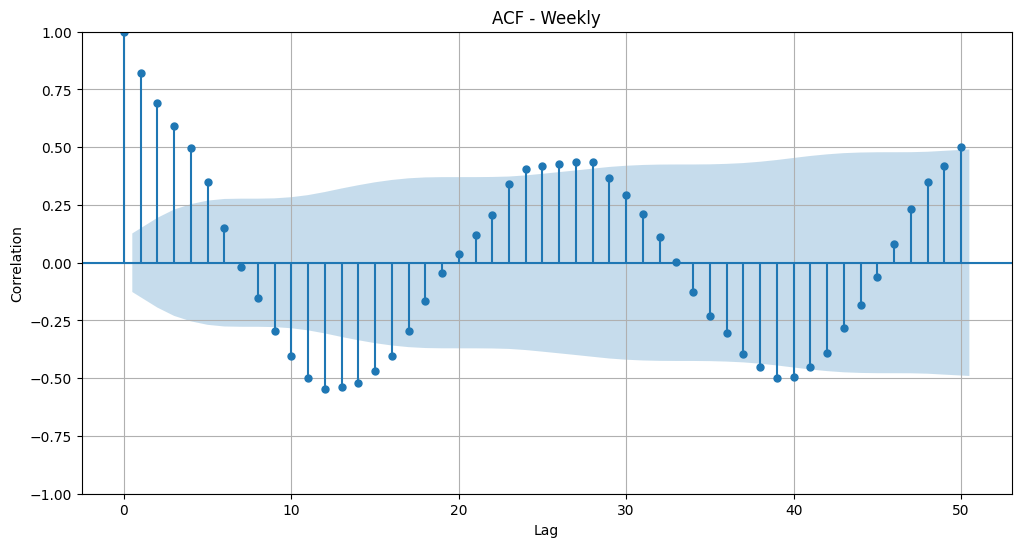

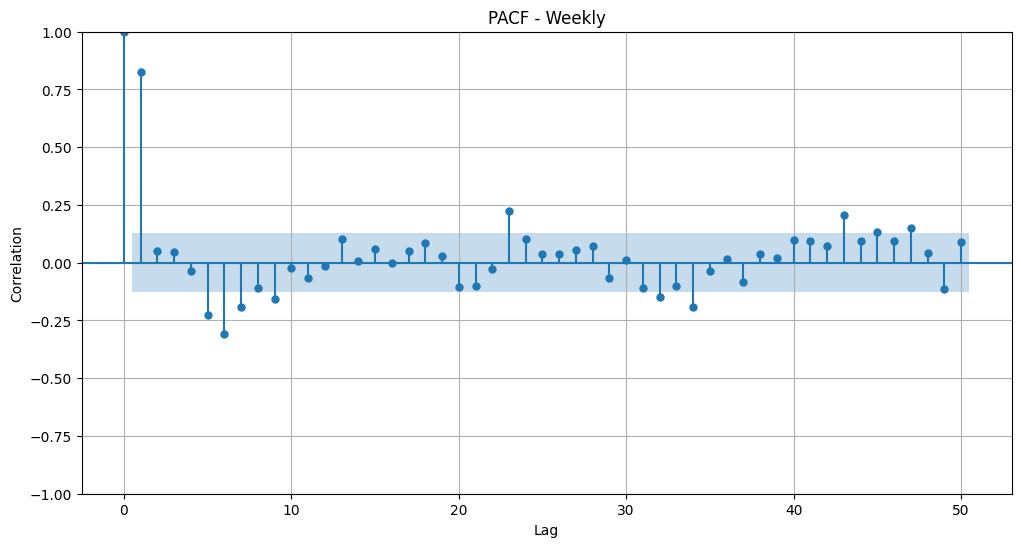

In [10]:
fig, ax = plt.subplots(figsize=(12, 6))
plot_acf(train.target.resample('W').mean(), lags=50, ax=ax, alpha=0.05, use_vlines=True)
plt.title('ACF - Weekly')
plt.xlabel('Lag')
plt.ylabel('Correlation')
plt.show()

fig, ax = plt.subplots(figsize=(12, 6))
plot_pacf(train.target.resample('W').mean(), lags=50, ax=ax, alpha=0.05, use_vlines=True)
plt.title('PACF - Weekly')
plt.xlabel('Lag')
plt.ylabel('Correlation')
plt.show()

__We can say that there are correlation at 3-6-9-12 months__

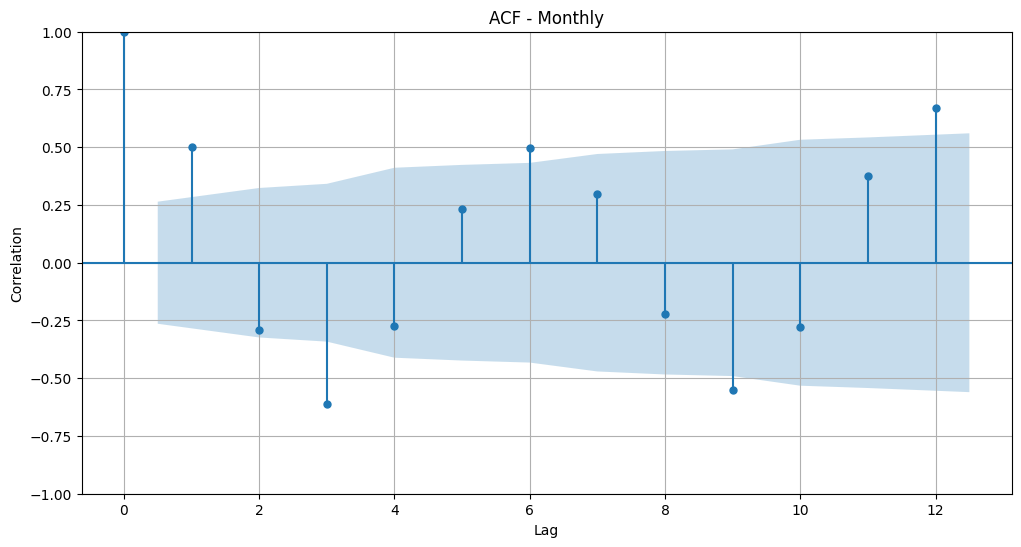

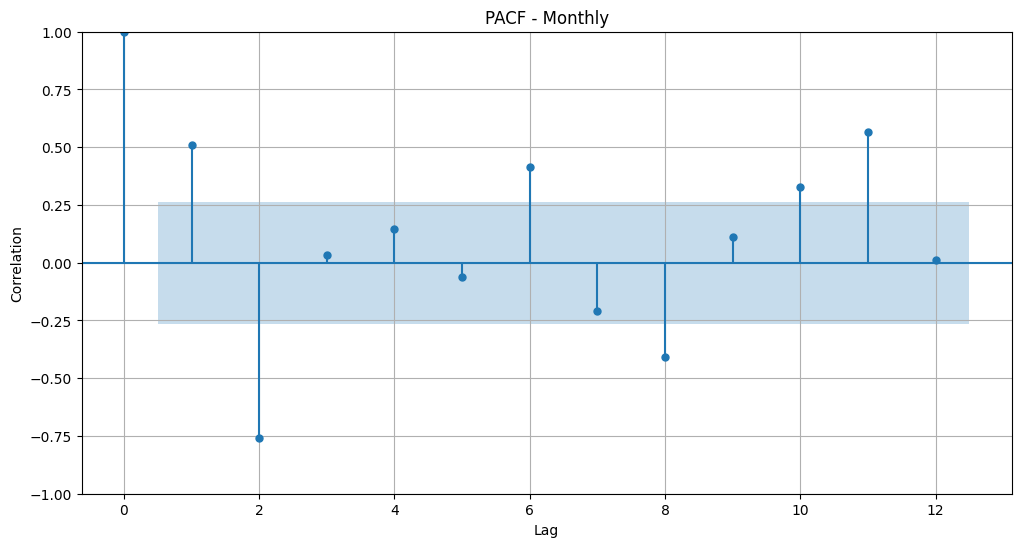

In [11]:
fig, ax = plt.subplots(figsize=(12, 6))
plot_acf(train.target.resample('M').mean(), lags=12, ax=ax, alpha=0.05, use_vlines=True)
plt.title('ACF - Monthly')
plt.xlabel('Lag')
plt.ylabel('Correlation')
plt.show()

fig, ax = plt.subplots(figsize=(12, 6))
plot_pacf(train.target.resample('M').mean(), lags=12, ax=ax, alpha=0.05, use_vlines=True)
plt.title('PACF - Monthly')
plt.xlabel('Lag')
plt.ylabel('Correlation')
plt.show()

__Lag Plots__

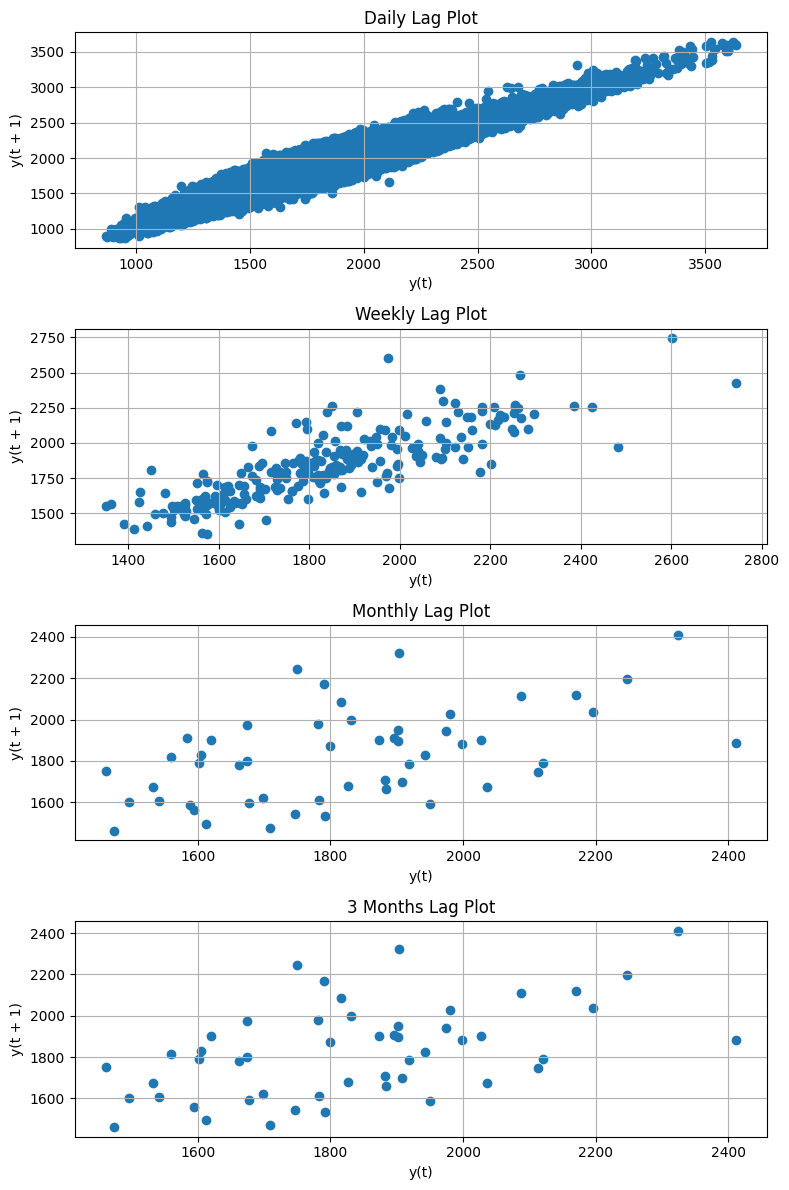

In [12]:
fig, axes = plt.subplots(nrows=4, ncols=1, figsize=(8, 12))

pd.plotting.lag_plot(train.target.shift(24), ax=axes[0])
axes[0].set_title('Daily Lag Plot')

pd.plotting.lag_plot(train.target.resample('W').mean().shift(1), ax=axes[1])
axes[1].set_title('Weekly Lag Plot')

pd.plotting.lag_plot(train.target.resample('M').mean().shift(1), ax=axes[2])
axes[2].set_title('Monthly Lag Plot')

pd.plotting.lag_plot(train.target.resample('M').mean().shift(3), ax=axes[3])
axes[3].set_title('3 Months Lag Plot')

plt.tight_layout()
plt.show()

***
## Outlier Detection

__Wtih DBSCAN algorithm__

In [13]:
def outliers_dbscan(data, eps=0.5, min_samples=5):

    X = data.reshape(-1, 1)

    dbscan = DBSCAN(eps=eps, min_samples=min_samples)
    dbscan.fit(X)

    labels = dbscan.labels_
    outliers = np.where(labels == -1)[0]
    outlier_values = data[outliers]

    return outliers, outlier_values

outliers, outlier_values = outliers_dbscan(train.target.values, eps=0.5, min_samples=3)

print("Detected {} outliers:".format(len(outliers)))
for i, idx in enumerate(outliers):
    print("Index {}: {}".format(idx, outlier_values[i]))

Detected 367 outliers:
Index 2524: 1062.2657853421529
Index 3006: 989.1889030983228
Index 3007: 966.5361145305196
Index 3174: 965.6084586224064
Index 3175: 993.1802039623044
Index 3197: 1063.5448841386803
Index 4014: 981.7828660803904
Index 4015: 1013.5933101357692
Index 4622: 2796.35544488608
Index 4624: 2796.5030462517257
Index 4886: 3014.777874400056
Index 4888: 2997.078988765254
Index 5104: 2901.375613696312
Index 5105: 2815.968302756876
Index 5126: 3101.3867305810604
Index 5127: 3086.7530510355973
Index 5128: 3079.0395752931813
Index 5150: 3011.937977917714
Index 5223: 2956.4736273396456
Index 5225: 2804.4766084298126
Index 5293: 2967.6072972038987
Index 5294: 3076.367578783026
Index 5295: 3071.4633972586
Index 5296: 3053.166660681182
Index 6871: 1029.558472781515
Index 7039: 1047.4266816231566
Index 11741: 1006.4092616089692
Index 11910: 975.7669604620384
Index 11911: 983.9043552662168
Index 12078: 972.273050692973
Index 12079: 994.5663387094338
Index 12482: 1047.376800561036
Ind

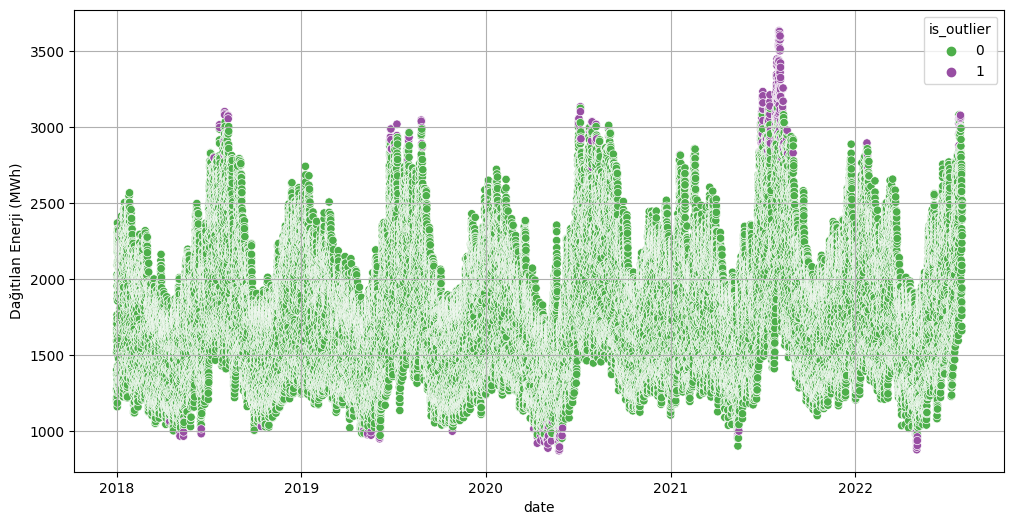

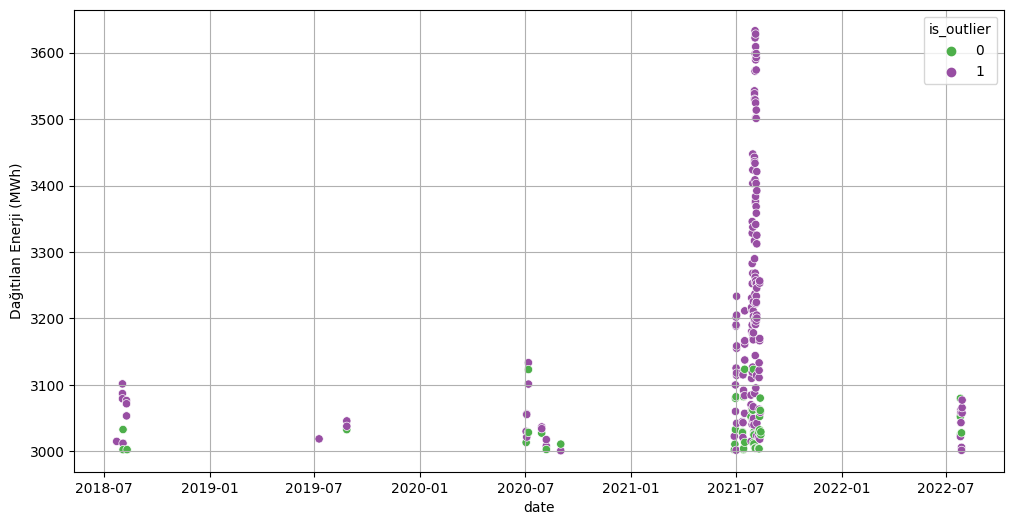

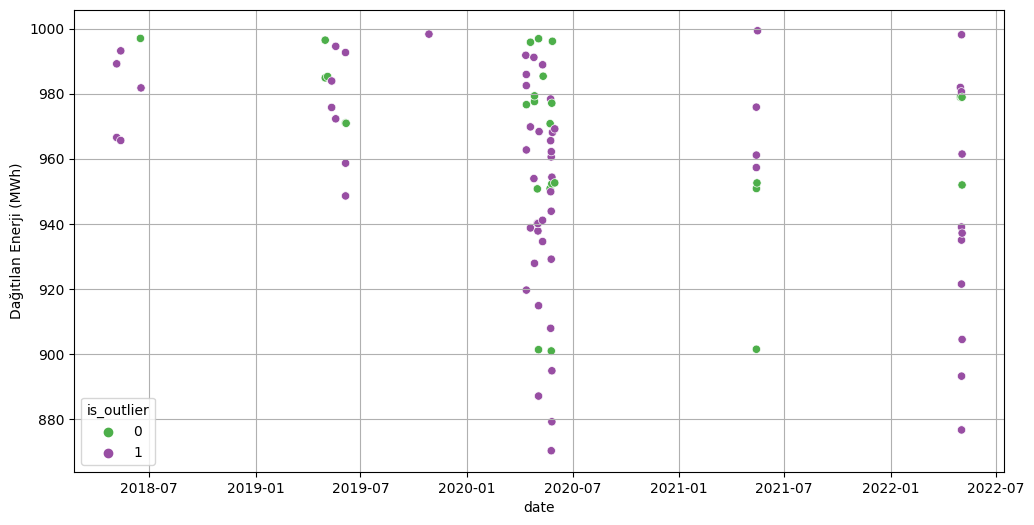

In [14]:
db['is_outlier'] = 0
db['is_outlier'].loc[outliers] = 1

plt.subplots()
sns.scatterplot(data=db,x=train.index,y=db['Dağıtılan Enerji (MWh)'],hue='is_outlier',palette=custom_palette[2:])
plt.show()

plt.subplots()
sns.scatterplot(data=db,x=train.index,y=db['Dağıtılan Enerji (MWh)'][db['Dağıtılan Enerji (MWh)']>3000],hue='is_outlier',palette=custom_palette[2:])
plt.show()

plt.subplots()
sns.scatterplot(data=db,x=train.index,y=db['Dağıtılan Enerji (MWh)'][db['Dağıtılan Enerji (MWh)']<1000],hue='is_outlier',palette=custom_palette[2:])
plt.show()

__With IQR method__

In [15]:
def outliers_iqr(data, threshold=1.5):
   

    q1, q3 = np.percentile(data, [25, 75])
    iqr = q3 - q1
    lower_bound = q1 - threshold * iqr
    upper_bound = q3 + threshold * iqr

    outliers = np.where((data < lower_bound) | (data > upper_bound))[0]
    outlier_values = data[outliers]

    return outliers, outlier_values

outliers, outlier_values = outliers_iqr(train.target.values, threshold=1.5)

print("Detected {} outliers:".format(len(outliers)))
for i, idx in enumerate(outliers):
    print("Index {}: {}".format(idx, outlier_values[i]))

Detected 126 outliers:
Index 5126: 3101.3867305810604
Index 5127: 3086.7530510355973
Index 5128: 3079.0395752931813
Index 5294: 3076.367578783026
Index 22022: 3133.3252841735566
Index 22023: 3122.968562703112
Index 22024: 3101.0619014813115
Index 30638: 3099.7771441890154
Index 30639: 3079.6369667291187
Index 30661: 3082.0557727774312
Index 30662: 3188.2104555035226
Index 30663: 3190.098608352351
Index 30664: 3201.9167691146395
Index 30665: 3125.1970077580845
Index 30683: 3114.268407137922
Index 30684: 3117.642625516454
Index 30685: 3154.930404624987
Index 30686: 3233.3110251095136
Index 30687: 3204.877942603036
Index 30688: 3158.564000031952
Index 30950: 3114.9206259170032
Index 30951: 3119.7365954648126
Index 30952: 3114.953169482903
Index 30974: 3091.65071283558
Index 30975: 3081.7711949092227
Index 30976: 3082.3173161560044
Index 31020: 3083.7374422154344
Index 31021: 3123.3627010978976
Index 31022: 3161.1935428485444
Index 31023: 3166.327139405366
Index 31024: 3211.352431039732
In

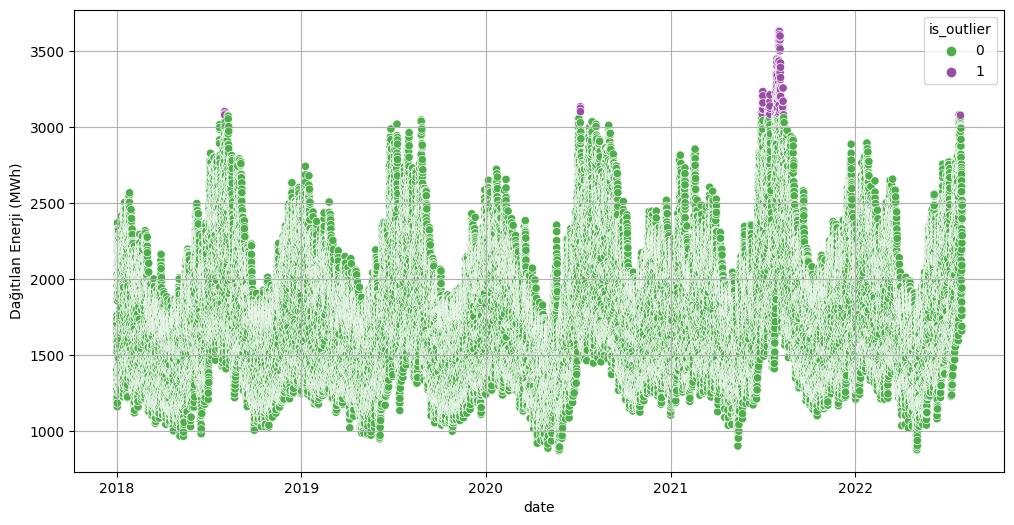

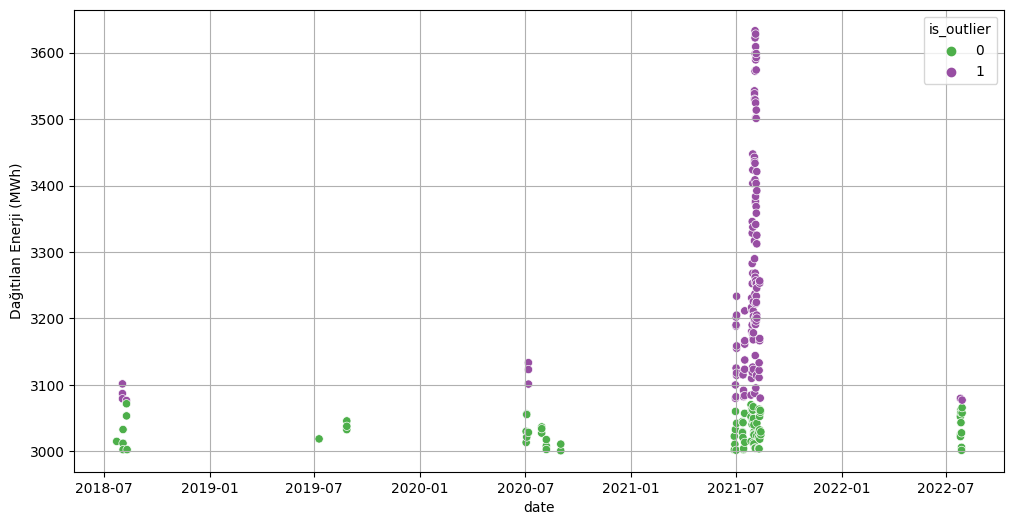

In [16]:
iqr['is_outlier'] = 0
iqr['is_outlier'].loc[outliers] = 1

plt.subplots()
sns.scatterplot(data=iqr,x=train.index,y=iqr['Dağıtılan Enerji (MWh)'],hue='is_outlier',palette=custom_palette[2:])
plt.show()

plt.subplots()
sns.scatterplot(data=iqr,x=train.index,y=iqr['Dağıtılan Enerji (MWh)'][iqr['Dağıtılan Enerji (MWh)']>3000],hue='is_outlier',palette=custom_palette[2:])
plt.show()

### Outlier Pipeline:
* __Set boundaries visually, with the help of DBSCAN / IQR__
* __Copy the serie, label detected outliers as NaN__
* __Since using interpolation changes the whole serie, fill NaN with linear interpolation on the copied serie__
* __Fill only the outlier indexes by copying from linearly interpolated serie__
* __Take the maximum of original value or interpolated value for lower outliers__
* __Take the minimum of original value or interpolated value for upper outliers__

In [17]:
upper_bound = 3100
lower_bound = 980

upper_index = train.loc[train.target > upper_bound].index
lower_index = train.loc[train.target < lower_bound].index

train['smoothen_target'] = train.target.values

train.loc[upper_index, 'smoothen_target'] = np.nan
train.loc[lower_index, 'smoothen_target'] = np.nan

train.smoothen_target = train.smoothen_target.interpolate(method='linear')


for idx in lower_index:
    
    value = max(train.target.loc[idx], train.smoothen_target.loc[idx])
    train.target.loc[idx] = value
    
for idx in upper_index:
    
    value = min(train.target.loc[idx], train.smoothen_target.loc[idx])
    train.target.loc[idx] = value

__Consequently, data is slightly trimmed:__

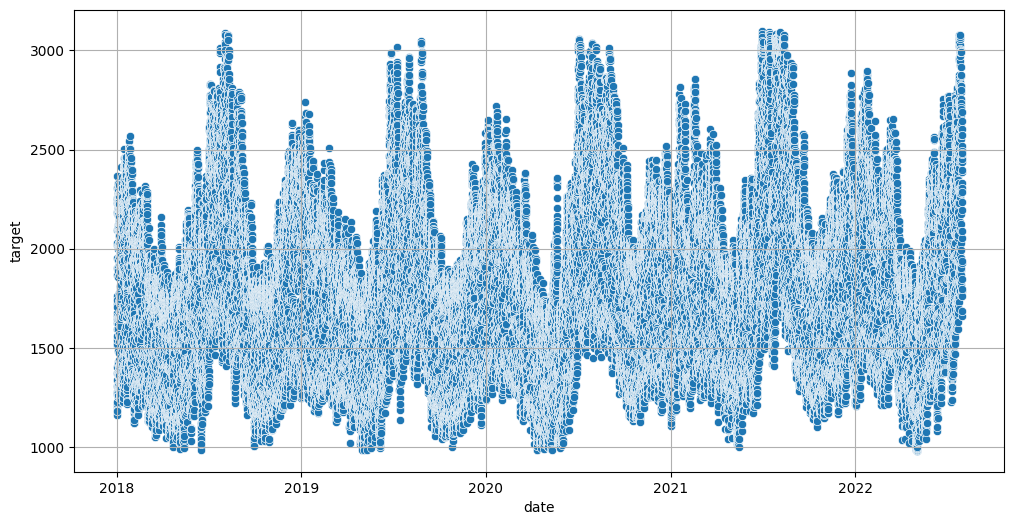

In [18]:
sns.scatterplot(data=train,x=train.index,y=train.target,palette=custom_palette)
plt.show()